# Topic Modeling

Outline:
1) LDA
2) BERTopic 
3) LLM
4) sLDA

## 1) LDA

In [1]:
import pandas as pd
# load publishers data from the corresponding file
publishers = pd.read_csv("../data/processed/publishers.csv") 

In [4]:
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim import corpora, models
# compute topic modeling for all publishers (append all the samples)
# Define safe filename generator
def safe_filename(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

# Concatenate all article samples
df_all = pd.concat([
    pd.read_csv(f"../data/processed/newspapers/sample_{safe_filename(pub)}.csv")
    for pub in publishers['publication']
], ignore_index=True)

# Tokenization and stopword removal using regex and sklearn stopwords
custom_stopwords = ENGLISH_STOP_WORDS.union({'said', 'mr', 'also'})

def tokenize_and_clean(text):
    # Keep words with 3 or more alphabetic characters
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return [t for t in tokens if t not in custom_stopwords]

df_all['tokens'] = df_all['article'].apply(tokenize_and_clean)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df_all['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df_all['tokens']]

# Train LDA model
num_topics = 10
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Plot wordclouds
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    topic_words = dict(lda_model.show_topic(idx, 50))
    wc = WordCloud(width=500, height=300, background_color='white', max_words=50)
    wc.generate_from_frequencies(topic_words)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Topic {idx + 1}', fontsize=14)
    ax.axis('off')

plt.suptitle('LDA Topics – Word Clouds', fontsize=18)
plt.show()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Save LDA model and dictionary
lda_model.save("../models/topic_model/lda_model.gensim")
dictionary.save("../models/topic_model/lda_dictionary.dict")

In [ ]:
from gensim import corpora, models

# Load model and dictionary
lda_model = models.LdaModel.load("../models/topic_model/lda_model.gensim")
dictionary = corpora.Dictionary.load("../models/topic_model/lda_dictionary.dict")

In [ ]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=lda_model, texts=df_all['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score (c_v): {coherence_score:.4f}')
# A score above 0.4 is generally considered good for topic coherence.

In [ ]:
from datetime import datetime
import re

# --- Assumes these exist ---
# - df['tokens'] = list of preprocessed word tokens
# - df['date'] = parsed datetime
# - df['publication'] = publisher name
# - lda_model = trained gensim LdaModel
# - dictionary = gensim Dictionary used to train the model

# Load all samples from new processed newspapers folder
df_all = pd.concat([pd.read_csv(f"../data/processed/newspapers/sample_{re.sub(r'\\W+','_ ', pub.lower()).strip('_')}.csv") for pub in publishers['publication']], ignore_index=True)

# Step 1: Convert tokens to bag-of-words
corpus = [dictionary.doc2bow(text) for text in df_all['tokens']]

# Step 2: Get topic distribution for each article
def get_topic_dist(bow):
    # Return full-length vector with zero entries where necessary
    dist = lda_model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in dist]

df_all['topic_distribution'] = [get_topic_dist(doc) for doc in corpus]

# Step 3: Unpack topic distributions into separate columns
num_topics = lda_model.num_topics
topic_cols = [f'topic_{i}' for i in range(num_topics)]
df_topics = pd.DataFrame(df_all['topic_distribution'].tolist(), columns=topic_cols)

# Step 4: Combine with metadata
df_meta = df_all[['date', 'publication']].copy()
df_combined = pd.concat([df_meta, df_topics], axis=1)
df_combined['month'] = pd.to_datetime(df_combined['date'], format='mixed', errors='coerce').dt.to_period('M')

# Step 5: Aggregate topic shares by month and publisher
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Step 6: Save to CSV
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher.csv', index=False)

print("Saved: 'monthly_topic_shares_by_publisher.csv'")

In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# --- 1. Load publisher article data ---
# Load publishers
publishers = pd.read_csv("../data/processed/publishers.csv")

# Define safe filename generator
def safe_filename(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

# Concatenate all article samples
df_all = pd.concat([
    pd.read_csv(f"../data/processed/newspapers/sample_{safe_filename(pub)}.csv")
    for pub in publishers['publication']
], ignore_index=True)

# --- 2. Define keyword filter ---
topic_keywords = [
    "manufacturing", "factory", "production", "industry", "output",
    "supply chain", "logistics", "transport", "shortage"
]

# --- 3. Clean and filter text ---
def clean_text(text_input):
    text_input = str(text_input).lower()
    text_input = re.sub(r'\d+', '', text_input)
    text_input = re.sub(f"[{re.escape(string.punctuation)}]", '', text_input)
    text_input = re.sub(r'\s+', ' ', text_input).strip()
    return text_input

def filter_keywords(text, keywords):
    text = text.lower()
    return ' '.join([
        word for word in text.split()
        if any(k in word for k in keywords)
    ])

# --- 4. Aggregate articles per month ---
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')
df_all['month'] = df_all['date'].dt.to_period('M').dt.to_timestamp()

df_monthly = df_all.groupby('month')['article'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# --- 5. Apply keyword filtering ---
df_monthly['filtered_content'] = df_monthly['article'].apply(lambda x: filter_keywords(x, topic_keywords))

# --- 6. Load IPI data and merge ---
df_indpro = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?id=INDPRO', parse_dates=['observation_date'])
df_indpro.rename(columns={'observation_date': 'date', 'INDPRO': 'ipi'}, inplace=True)
df_indpro['month'] = df_indpro['date'].dt.to_period('M').dt.to_timestamp()

df_keywords_monthly = pd.merge(df_monthly, df_indpro[['month', 'ipi']], on='month', how='inner')

# --- 7. TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=10,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',
    preprocessor=clean_text
)

X_tfidf = vectorizer.fit_transform(df_keywords_monthly['filtered_content'].fillna(''))

df_features = pd.DataFrame(
    X_tfidf.toarray(),
    columns=[f"kw_{word}" for word in vectorizer.get_feature_names_out()]
)
df_features['month'] = df_keywords_monthly['month'].values
df_features['ipi'] = df_keywords_monthly['ipi'].values

# --- 8. Save final DataFrame ---
df_features.to_csv("../data/processed/df_industry_keywords_monthly.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/newspapers/sample_reuters.csv'

## 2) BERTopic

Goal: Topic shares by month-publisher using BERTopic for the topic modeling. 

In [1]:
# Imports
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from difflib import get_close_matches
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from difflib import get_close_matches
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

# Load and clean data
publishers = pd.read_csv("../data/processed/publishers.csv")
data_dir = "../data/processed/newspapers/"
available_files = os.listdir(data_dir)

available_basenames = {
    re.sub(r'^sample_|\.csv$', '', fname): fname
    for fname in available_files
    if fname.startswith("sample_") and fname.endswith(".csv")
}

def sanitize(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

dfs = []
for pub in tqdm(publishers['publication'], desc="Loading data"):
    pub_clean = sanitize(pub)
    match = get_close_matches(pub_clean, available_basenames.keys(), n=1, cutoff=0.7)
    if match:
        dfs.append(pd.read_csv(os.path.join(data_dir, available_basenames[match[0]])))
    else:
        print(f"No file found for: {pub}")

df_all = pd.concat(dfs, ignore_index=True)

# Clean text
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return ' '.join([t for t in tokens if t not in stop_words])

df_all['clean_text'] = df_all['article'].astype(str).apply(clean_text)
df_all = df_all[df_all['clean_text'].str.split().str.len() > 20].reset_index(drop=True)

# Batched Embeddings
print("Generating text embeddings in batches...")
embed_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
texts = df_all['clean_text'].tolist()
batch_size = 10000
all_embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch = texts[i:i+batch_size]
    embeddings = embed_model.encode(batch, show_progress_bar=True)
    all_embeddings.append(embeddings)

embeddings = np.vstack(all_embeddings)

[nltk_data] Downloading package stopwords to /Users/rada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading data: 100%|██████████| 26/26 [00:08<00:00,  3.05it/s]


Generating text embeddings in batches...


Embedding batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   4%|▍         | 1/24 [00:13<05:18, 13.85s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   8%|▊         | 2/24 [00:28<05:15, 14.34s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  12%|█▎        | 3/24 [00:40<04:40, 13.37s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  17%|█▋        | 4/24 [00:53<04:23, 13.17s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  21%|██        | 5/24 [01:05<04:01, 12.74s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  25%|██▌       | 6/24 [01:19<03:54, 13.01s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  29%|██▉       | 7/24 [01:31<03:39, 12.91s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  33%|███▎      | 8/24 [01:44<03:23, 12.74s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  38%|███▊      | 9/24 [01:56<03:08, 12.55s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  42%|████▏     | 10/24 [02:09<02:58, 12.76s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  46%|████▌     | 11/24 [02:21<02:42, 12.50s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  50%|█████     | 12/24 [02:32<02:24, 12.07s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  54%|█████▍    | 13/24 [02:42<02:05, 11.37s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  58%|█████▊    | 14/24 [02:55<01:57, 11.78s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  62%|██████▎   | 15/24 [03:09<01:52, 12.53s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  67%|██████▋   | 16/24 [03:22<01:42, 12.79s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  71%|███████   | 17/24 [03:35<01:29, 12.78s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  75%|███████▌  | 18/24 [03:48<01:16, 12.81s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  79%|███████▉  | 19/24 [04:00<01:03, 12.70s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  83%|████████▎ | 20/24 [04:12<00:50, 12.50s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  88%|████████▊ | 21/24 [04:25<00:38, 12.68s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  92%|█████████▏| 22/24 [04:40<00:26, 13.17s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  96%|█████████▌| 23/24 [04:54<00:13, 13.41s/it]

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Embedding batches: 100%|██████████| 24/24 [05:07<00:00, 12.81s/it]


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
from umap import UMAP
from bertopic import BERTopic

# Dimensionality reduction
umap_model = UMAP(n_components=5, random_state=42)

# KMeans clustering
num_topics = 10
kmeans_model = KMeans(n_clusters=num_topics, random_state=42)

# Initialize BERTopic
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=kmeans_model,
    embedding_model=None,
    language="english",
    calculate_probabilities=True,
    verbose=True,
)

# Fit and transform
print("Fitting BERTopic...")
topics, probs = topic_model.fit_transform(texts, embeddings)

# Save results
topic_model.save("../models/topic_model/bertopic_model")
np.save("../models/topic_model/bertopic_embeddings.npy", embeddings)

2025-07-16 10:56:09,316 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting BERTopic...


2025-07-16 10:59:20,938 - BERTopic - Dimensionality - Completed ✓
2025-07-16 10:59:20,942 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-16 10:59:22,621 - BERTopic - Cluster - Completed ✓
2025-07-16 10:59:22,645 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-16 10:59:53,659 - BERTopic - Representation - Completed ✓
2025-07-16 10:59:54,303 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [3]:
# Get number of real topics
topic_ids = sorted([t for t in topic_model.get_topics().keys() if t != -1])
topic_cols = [f"topic_{i}" for i in topic_ids]

df_meta = df_all[['date', 'publication']].reset_index(drop=True)
df_combined = df_meta.copy()
df_combined['topic'] = topics

# Extract month
df_combined['month'] = pd.to_datetime(df_combined['date'], format='mixed', errors='coerce').dt.to_period('M')

# One-hot encode topics
df_onehot = pd.get_dummies(df_combined['topic'], prefix='topic')

# Combine with meta
df_combined = pd.concat([df_combined[['month', 'publication']], df_onehot], axis=1)

# Group by month + publisher and average (which is topic share)
df_monthly_pub = df_combined.groupby(['month', 'publication']).mean().reset_index()

# Save result
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_bertopic.csv', index=False)
print("Saved: 'monthly_topic_shares_by_publisher_bertopic.csv'")


Saved: 'monthly_topic_shares_by_publisher_bertopic.csv'


## 3) LLM

In [1]:
# Imports
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import re
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from difflib import get_close_matches
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

# Load and clean data
publishers = pd.read_csv("../data/processed/publishers.csv")
data_dir = "../data/processed/newspapers/"
available_files = os.listdir(data_dir)

available_basenames = {
    re.sub(r'^sample_|\.csv$', '', fname): fname
    for fname in available_files
    if fname.startswith("sample_") and fname.endswith(".csv")
}

def sanitize(pub):
    return re.sub(r'\W+', '_', pub.lower()).strip('_')

dfs = []
for pub in tqdm(publishers['publication'], desc="Loading data"):
    pub_clean = sanitize(pub)
    match = get_close_matches(pub_clean, available_basenames.keys(), n=1, cutoff=0.7)
    if match:
        dfs.append(pd.read_csv(os.path.join(data_dir, available_basenames[match[0]])))
    else:
        print(f"No file found for: {pub}")

df_all = pd.concat(dfs, ignore_index=True)

# Clean text
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return ' '.join([t for t in tokens if t not in stop_words])

df_all['clean_text'] = df_all['article'].astype(str).apply(clean_text)
df_all = df_all[df_all['clean_text'].str.split().str.len() > 20].reset_index(drop=True)

# Batched Embeddings
print("Generating text embeddings in batches...")
embed_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
texts = df_all['clean_text'].tolist()
batch_size = 10000
all_embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch = texts[i:i+batch_size]
    embeddings = embed_model.encode(batch, show_progress_bar=True)
    all_embeddings.append(embeddings)

embeddings = np.vstack(all_embeddings)

[nltk_data] Downloading package stopwords to /Users/rada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading data: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s]


Generating text embeddings in batches...


Embedding batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   4%|▍         | 1/24 [00:19<07:26, 19.41s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:   8%|▊         | 2/24 [00:45<08:34, 23.36s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  12%|█▎        | 3/24 [01:06<07:49, 22.37s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  17%|█▋        | 4/24 [01:27<07:18, 21.92s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  21%|██        | 5/24 [01:46<06:31, 20.63s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  25%|██▌       | 6/24 [02:08<06:18, 21.02s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  29%|██▉       | 7/24 [02:28<05:56, 20.94s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  33%|███▎      | 8/24 [02:51<05:44, 21.55s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  38%|███▊      | 9/24 [03:13<05:24, 21.63s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  42%|████▏     | 10/24 [03:36<05:10, 22.16s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  46%|████▌     | 11/24 [03:57<04:40, 21.59s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  50%|█████     | 12/24 [04:14<04:04, 20.38s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  54%|█████▍    | 13/24 [04:28<03:22, 18.41s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  58%|█████▊    | 14/24 [04:50<03:15, 19.53s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  62%|██████▎   | 15/24 [05:18<03:17, 22.00s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  67%|██████▋   | 16/24 [05:43<03:02, 22.85s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  71%|███████   | 17/24 [06:07<02:43, 23.29s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  75%|███████▌  | 18/24 [06:30<02:18, 23.04s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  79%|███████▉  | 19/24 [06:51<01:52, 22.52s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  83%|████████▎ | 20/24 [07:12<01:28, 22.07s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  88%|████████▊ | 21/24 [07:35<01:07, 22.34s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  92%|█████████▏| 22/24 [08:01<00:46, 23.41s/it]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Embedding batches:  96%|█████████▌| 23/24 [08:28<00:24, 24.44s/it]

Batches:   0%|          | 0/241 [00:00<?, ?it/s]

Embedding batches: 100%|██████████| 24/24 [08:59<00:00, 22.49s/it]


In [3]:
# KMeans clustering
num_topics = 10
kmeans = KMeans(n_clusters=num_topics, random_state=42)
df_all['topic_cluster'] = kmeans.fit_predict(embeddings)

# Load TinyLlama locally
print("Loading TinyLlama model...")
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0").to(device)

topic_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if device == 'cuda' else -1
)

# Generate topic label per cluster
def generate_cluster_topic(texts):
    sample_text = "\n\n".join(texts)
    prompt = f"""Given the following news article excerpts, identify the main shared topic.  
Respond with only 1–3 words (e.g., 'climate change', 'US politics', etc.).

Example:
Articles:
Article 1: The president signed a new climate treaty...
Article 2: World leaders gathered to address emissions...
Topic: climate change

Now do the same for these articles:
{sample_text}

Topic:"""
    try:
        output = topic_pipe(prompt, max_new_tokens=30, temperature=0.7, top_k=40, do_sample=True)
        generated = output[0]["generated_text"]
        return generated.split("Topic:")[-1].strip().split("\n")[0]
    except Exception as e:
        return f"Error: {e}"

print("Generating topic labels per cluster...")
llama_topic_labels = {}
n_samples_per_cluster = 10

for cluster_id in range(num_topics):
    cluster_docs = df_all[df_all['topic_cluster'] == cluster_id]['clean_text']
    if not cluster_docs.empty:
        # Get embeddings of documents in the cluster
        cluster_indices = df_all[df_all['topic_cluster'] == cluster_id].index
        cluster_embeddings = embeddings[cluster_indices]

        # Compute distances to cluster center
        center = kmeans.cluster_centers_[cluster_id]
        dists = np.linalg.norm(cluster_embeddings - center, axis=1)

        # Get indices of n closest documents
        closest_indices = cluster_indices[np.argsort(dists)[:n_samples_per_cluster]]

        # Extract clean texts
        samples = [" ".join(df_all.loc[i, 'clean_text'].split()[:50]) for i in closest_indices]

        topic_label = generate_cluster_topic(samples)
        llama_topic_labels[cluster_id] = topic_label
        print(f"Cluster {cluster_id}: {topic_label}")
    else:
        llama_topic_labels[cluster_id] = "No documents"

# Topic distribution per document
print("Calculating topic distributions...")
similarities = cosine_similarity(embeddings, kmeans.cluster_centers_)
topic_cols = [f'topic_{i}' for i in range(num_topics)]
df_topic_dist = pd.DataFrame(similarities, columns=topic_cols)
df_all = pd.concat([df_all, df_topic_dist], axis=1)

# Temporal aggregation
print("Aggregating over time and publisher...")
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')
df_all['month'] = df_all['date'].dt.to_period('M')

df_combined = pd.concat([df_all[['month', 'publication']], df_all[topic_cols]], axis=1)
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Save
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_tinyllama.csv', index=False)
print("Saved: 'monthly_topic_shares_by_publisher_tinyllama.csv'")

# Print cluster topics
print("\nFinal Topic Labels:")
for cid, label in llama_topic_labels.items():
    print(f"Topic {cid}: {label}")

/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Loading TinyLlama model...


Device set to use mps:0


Generating topic labels per cluster...
Cluster 0: healthcare
Cluster 1: self-love
Cluster 2: Impeachment
Cluster 3: Trump investigation, impeachment, Mueller, Russian collusion
Cluster 4: US politics
Cluster 5: political unrest
Cluster 6: popular culture
Cluster 7: AR
Cluster 8: art history
Cluster 9: Climate Change
Calculating topic distributions...
Aggregating over time and publisher...
Saved: 'monthly_topic_shares_by_publisher_tinyllama.csv'

Final Topic Labels:
Topic 0: healthcare
Topic 1: self-love
Topic 2: Impeachment
Topic 3: Trump investigation, impeachment, Mueller, Russian collusion
Topic 4: US politics
Topic 5: political unrest
Topic 6: popular culture
Topic 7: AR
Topic 8: art history
Topic 9: Climate Change


## 4) Supervised LDA (sLDA) Implementation with Tomotopy

Unlike the previous approach that used a two-stage method (sklearn LDA + Linear Regression), we'll implement true supervised LDA using tomotopy, which integrates the supervision signal (IPI data) directly into the topic modeling process.

In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import tomotopy as tp  # We're using tomotopy for supervised LDA
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Preparation

Let's load the pre-processed newspaper data and the IPI (supervision) data for sLDA modeling.

In [6]:
# Load publishers information
publishers = pd.read_csv("../data/processed/publishers.csv")
print(f"Loaded information for {len(publishers)} publishers")

# Load all samples from processed newspapers folder
# Create a function to convert publisher names to filenames
def publisher_to_filename(publisher_name):
    # Replace special characters with underscores
    return f"sample_{re.sub(r'\W+', '_', publisher_name.lower()).strip('_')}.csv"

# Load all sample files
df_all = pd.concat([
    pd.read_csv(f"../data/processed/newspapers/{publisher_to_filename(pub)}")
    for pub in publishers['publication']
], ignore_index=True)

print(f"Loaded {len(df_all)} newspaper articles")
print(f"Sample data columns: {df_all.columns.tolist()}")

# Examine the first rows to understand the data
df_all.head()

Loaded information for 26 publishers
Loaded 254701 newspaper articles
Sample data columns: ['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url', 'section', 'publication']


,date,year,month,day,author,title,article,url,section,publication
0,2018-06-13,2018,6.0,13,NaN,Volkswagen CEO says still trying to overcome d...,BERLIN (Reuters) - Volkswagen’s (VOWG_p.DE) ne...,https://www.reuters.com/article/us-volkswagen-...,Environment,Reuters
1,2018-11-09,2018,11.0,9,"Jalil Ahmad Rezayee, Storay Karimi",Displaced victims of worst Afghan drought in y...,"HERAT, Afghanistan (Reuters) - Mahiuddin, a 35...",https://www.reuters.com/article/us-afghanistan...,Environment,Reuters
2,2020-03-11,2020,3.0,11,NaN,UK announces five billion pound emergency resp...,LONDON (Reuters) - Finance minister Rishi Suna...,https://www.reuters.com/article/us-britain-bud...,Business News,Reuters
3,2016-11-02,2016,11.0,2,NaN,Fitch: No Impact on Ardshinbank's Ratings from...,(The following statement was released by the r...,http://www.reuters.com/article/idUSFit978977,Intel,Reuters
4,2019-10-15,2019,10.0,15,NaN,U.S. to push diplomacy in bid to halt Syria at...,"WASHINGTON, Oct 15 (Reuters) - The United Stat...",https://www.reuters.com/article/syria-security...,Market News,Reuters


In [7]:
# Load IPI (response variable) data - this is monthly data that we'll use for supervision
df_ipi = pd.read_csv("../data/processed/ipi_data.csv")

# Display the IPI data
print(f"Loaded IPI data with {len(df_ipi)} records")
print("Columns in df_ipi:", df_ipi.columns.tolist())
df_ipi.head()

Loaded IPI data with 3432 records
Columns in df_ipi: ['month', 'publication', 'ipi_value']


,month,publication,ipi_value
0,2010-01,Reuters,89.1897
1,2010-01,The New York Times,89.1897
2,2010-01,CNBC,89.1897
3,2010-01,The Hill,89.1897
4,2010-01,People,89.1897


### Merge newspaper data with IPI data

Since IPI data is monthly while newspaper text is at article level, we need to merge them to assign the monthly IPI values to each article in the corresponding month and publication. The newspaper data uses YYYY-MM-DD format for dates while the IPI data uses YYYY-MM format.

In [8]:
# Create month_key in df_all to match df_ipi format
# Remove time component if present and convert to month_key
df_all['month_key'] = pd.to_datetime(df_all['date'].str.split().str[0]).dt.strftime('%Y-%m')

# Merge the dataframes on month_key and publication
df_merged = pd.merge(
    df_all, 
    df_ipi[['month', 'publication', 'ipi_value']], 
left_on=['month_key', 'publication'],
    right_on=['month', 'publication']
)

# Consolidate 'month' column:
# If 'month_y' (from df_ipi) exists, rename it to 'month'.
# If 'month_x' (from df_all) also exists, it's likely redundant with 'month_key' or not the IPI-aligned month, so drop it.
if 'month_y' in df_merged.columns:
    df_merged.rename(columns={'month_y': 'month'}, inplace=True)
    if 'month_x' in df_merged.columns:
        df_merged.drop(columns=['month_x'], inplace=True, errors='ignore')
elif 'month' not in df_merged.columns:
    # This case should ideally not happen if the merge is successful and df_ipi has 'month'
    print("Warning: 'month' column is missing after merge and suffix handling.")


print("Columns in df_merged after merge and rename:", df_merged.columns.tolist())

print(f"Merged data shape: {df_merged.shape}")
print("\nSample of merged data:")
print(df_merged[['date', 'publication', 'month_key', 'ipi_value']].head())

Columns in df_merged after merge and rename: ['date', 'year', 'day', 'author', 'title', 'article', 'url', 'section', 'publication', 'month_key', 'month', 'ipi_value']
Merged data shape: (254701, 12)

Sample of merged data:
         date publication month_key  ipi_value
0  2018-06-13     Reuters   2018-06   103.2256
1  2018-11-09     Reuters   2018-11   104.0126
2  2020-03-11     Reuters   2020-03    97.6060
3  2016-11-02     Reuters   2016-11    98.3443
4  2019-10-15     Reuters   2019-10   101.5878


### Model Training & Evaluation

Now we'll implement supervised LDA using tomotopy's SLDAModel, which directly incorporates the IPI values during topic inference. The `vars` parameter in SLDAModel specifies that we have one continuous response variable (the normalized IPI value).

In [ ]:
# NEW CODE - entire pipeline using XGBoost for training #
"""
Leak-safe sLDA → downstream ML (monthly IPI prediction) pipeline.

Requirements:
    pip install tomotopy lightgbm xgboost catboost scikit-learn matplotlib pandas numpy
Inputs:
    df_merged: DataFrame in memory with at least:
        - 'date' (parseable datetime)
        - 'ipi_value' (numeric monthly IPI level for each doc's date)
        - 'article' OR 'content' (text)
Optional:
    'publication' column (used for diagnostics only; not required)

Outputs saved:
    ../data/processed/slda_doc_level_features.csv        # doc-level θ + predictions (test only)
    ../data/processed/slda_monthly_features.csv          # monthly θ + actual + predictions
    ../models/slda_lightgbm_model.txt                    # trained downstream ML model (LightGBM)
"""

import os
import numpy as np
import pandas as pd
import tomotopy as tp
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor  # change model here if you prefer

# ------------------------------------------------------------------
# 0. USER CONFIG
# ------------------------------------------------------------------
num_topics        = 10
train_frac        = 0.80      # chronological split
slda_iters        = 500       # training iterations
infer_iters       = 100       # inference iterations for test docs
use_length_weight = True      # weight monthly topic averages by doc length (# tokens)
random_state      = 42

# If df_merged is NOT in memory, uncomment and set path:
# df_merged = pd.read_csv("../data/processed/df_merged.csv")

# ------------------------------------------------------------------
# 1. Stopwords + tokenizer (adapt as needed)
# ------------------------------------------------------------------
stopwords = set([
    'i','me','my','myself','we','our','ours','ourselves','you',"you're","you've",
    "you'll","you'd",'your','yours','yourself','yourselves','he','him','his',
    'himself','she',"she's",'her','hers','herself','it',"it's",'its','itself',
    'they','them','their','theirs','themselves','what','which','who','whom','this',
    'that',"that'll",'these','those','am','is','are','was','were','be','been','being',
    'have','has','had','having','do','does','did','doing','a','an','the','and','but',
    'if','or','because','as','until','while','of','at','by','for','with','about',
    'against','between','into','through','during','before','after','above','below','to',
    'from','up','down','in','out','on','off','over','under','again','further','then',
    'once','here','there','when','where','why','how','all','any','both','each','few',
    'more','most','other','some','such','no','nor','not','only','own','same','so',
    'than','too','very','s','t','can','will','just','don',"don't",'should',"should've",
    'now','d','ll','m','o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",
    'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",
    'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',
    "shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",
    'wouldn',"wouldn't",'said','mr','also'
])

import re
def preprocess_text(text):
    tokens = re.findall(r'\b[a-z]{3,}\b', str(text).lower())
    return [t for t in tokens if t not in stopwords]


# ------------------------------------------------------------------
# 2. Prep data: date, sort, split
# ------------------------------------------------------------------
text_column = 'article' if 'article' in df_merged.columns else 'content'

df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged = df_merged.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

split_idx = int(len(df_merged) * train_frac)
df_train = df_merged.iloc[:split_idx].copy()
df_test  = df_merged.iloc[split_idx:].copy()

print(f"Train docs: {len(df_train)}, Test docs: {len(df_test)}")


# ------------------------------------------------------------------
# 3. Tokenize
# ------------------------------------------------------------------
docs_tokens_train = df_train[text_column].apply(preprocess_text).tolist()
docs_tokens_test  = df_test[text_column].apply(preprocess_text).tolist()


# ------------------------------------------------------------------
# 4. Targets
# ------------------------------------------------------------------
ipi_train = df_train['ipi_value'].astype(float).to_numpy()
ipi_test  = df_test['ipi_value'].astype(float).to_numpy()

# Standardize target for sLDA supervision
mean_ipi = ipi_train.mean()
std_ipi  = ipi_train.std(ddof=0)
ipi_train_z = (ipi_train - mean_ipi) / std_ipi


# ------------------------------------------------------------------
# 5. Fit sLDA on TRAIN ONLY (avoids leakage)
# ------------------------------------------------------------------
mdl = tp.SLDAModel(
    k=num_topics, alpha=0.05, eta=0.01,
    seed=random_state, vars=['l']
)

# add docs: if tokens empty, we skip (doc contributes nothing)
for toks, z in zip(docs_tokens_train, ipi_train_z):
    if toks:
        mdl.add_doc(toks, [float(z)])

print(f"Training on {len(mdl.docs)} non-empty train docs...")
mdl.train(slda_iters)


# ------------------------------------------------------------------
# 6. Extract TRAIN topic proportions (θ) from model docs
#     mdl.docs corresponds exactly to train docs we added (order preserved)
# ------------------------------------------------------------------
theta_train = np.vstack([d.get_topic_dist() for d in mdl.docs])

# we need alignment: some train docs may have been empty & skipped
# so build an aligned array with NaNs where skipped
theta_train_aligned = np.full((len(df_train), num_topics), np.nan, dtype=float)

train_idx_nonempty = [i for i,(toks) in enumerate(docs_tokens_train) if toks]
theta_train_aligned[train_idx_nonempty, :] = theta_train


# ------------------------------------------------------------------
# 7. Infer TEST topic proportions
# ------------------------------------------------------------------
theta_test_aligned = np.full((len(df_test), num_topics), np.nan, dtype=float)

for i, toks in enumerate(docs_tokens_test):
    if not toks:
        continue
    doc = mdl.make_doc(toks)
    theta, _ = mdl.infer(doc, iter=infer_iters)
    theta_test_aligned[i, :] = theta


# ------------------------------------------------------------------
# 8. Build DOC-LEVEL feature DataFrames
# ------------------------------------------------------------------
topic_cols = [f"topic_{j}" for j in range(num_topics)]

df_train_theta = pd.DataFrame(theta_train_aligned, columns=topic_cols, index=df_train.index)
df_test_theta  = pd.DataFrame(theta_test_aligned,  columns=topic_cols, index=df_test.index)

df_train_doc = pd.concat([df_train[['date','ipi_value']], df_train_theta], axis=1)
df_test_doc  = pd.concat([df_test[['date','ipi_value']],  df_test_theta],  axis=1)

# for later: doc length (tokens count)
df_train_doc['doc_len'] = [len(t) for t in docs_tokens_train]
df_test_doc['doc_len']  = [len(t) for t in docs_tokens_test]

# ------------------------------------------------------------------
# 9. Aggregate to MONTHLY features (since IPI is monthly)
# ------------------------------------------------------------------
def to_month(df):
    return df['date'].dt.to_period('M').dt.to_timestamp()

df_train_doc['month'] = to_month(df_train_doc)
df_test_doc['month']  = to_month(df_test_doc)

agg_dict = {}
for c in topic_cols:
    if use_length_weight:
        # weighted mean topic share by doc length
        agg_dict[c] = lambda x, col=c: np.average(
            df_train_doc.loc[x.index, col] if col in x.name else x,  # weird lambda scoping issue avoided below
            weights=df_train_doc.loc[x.index, 'doc_len']
        )
# The lambda trick above is messy. Easier: merge weights, then group manually.
# Let's do an explicit weighted aggregation instead of agg_dict:

def weighted_monthly_topics(df):
    out_rows = []
    for m, grp in df.groupby('month'):
        w = grp['doc_len'].to_numpy()
        w = np.where(np.isfinite(w) & (w>0), w, 1.0)
        theta_mat = grp[topic_cols].to_numpy()
        # rows may have NaNs (empty docs); mask them
        mask = np.isfinite(theta_mat).all(axis=1)
        if mask.sum() == 0:
            # fallback: uniform
            w_theta = np.full(num_topics, np.nan)
        else:
            w = w[mask]
            theta_mat = theta_mat[mask]
            w_theta = np.average(theta_mat, axis=0, weights=w)
        out_rows.append((m, *w_theta, grp['ipi_value'].mean()))
    cols = ['month'] + topic_cols + ['ipi_value']
    return pd.DataFrame(out_rows, columns=cols)

monthly_train = weighted_monthly_topics(df_train_doc)
monthly_test  = weighted_monthly_topics(df_test_doc)

# If not weighting, replace the above with simple mean:
# monthly_train = df_train_doc.groupby('month')[topic_cols + ['ipi_value']].mean().reset_index()
# monthly_test  = df_test_doc.groupby('month')[topic_cols + ['ipi_value']].mean().reset_index()


# ------------------------------------------------------------------
# 10. Downstream ML model (train on monthly)
# ------------------------------------------------------------------
X_train = monthly_train[topic_cols].to_numpy()
y_train = monthly_train['ipi_value'].to_numpy()

X_test  = monthly_test[topic_cols].to_numpy()
y_test  = monthly_test['ipi_value'].to_numpy()

# LightGBM regressor (change as you like)
ml_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=random_state,
    verbose=-1
)
ml_model.fit(X_train, y_train)

y_pred_test = ml_model.predict(X_test)

# metrics
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)
corr = np.corrcoef(y_test, y_pred_test)[0,1]

print("\n=== Downstream ML (Monthly) Performance ===")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R^2 : {r2:.4f}")
print(f"Test Corr: {corr:.4f}")


# ------------------------------------------------------------------
# 11. Attach predictions to monthly_test DataFrame
# ------------------------------------------------------------------
monthly_test = monthly_test.copy()
monthly_test['IPI_predicted'] = y_pred_test
monthly_test.rename(columns={'ipi_value':'IPI_actual'}, inplace=True)

# Optionally include train fit (in-sample)
monthly_train_pred = monthly_train.copy()
monthly_train_pred['IPI_predicted'] = ml_model.predict(X_train)
monthly_train_pred.rename(columns={'ipi_value':'IPI_actual'}, inplace=True)
monthly_train_pred['set'] = 'train'
monthly_test['set'] = 'test'

monthly_all = pd.concat([monthly_train_pred, monthly_test], ignore_index=True)


# ------------------------------------------------------------------
# 12. Save outputs
# ------------------------------------------------------------------
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# doc-level (test only to avoid giant file; change if needed)
df_test_doc_out = df_test_doc.copy()
df_test_doc_out.to_csv("../data/processed/slda_doc_level_features.csv", index=False)

monthly_all.to_csv("../data/processed/slda_monthly_features.csv", index=False)

# save model (LightGBM's built-in)
ml_model.booster_.save_model("../models/slda_lightgbm_model.txt")

print("Saved:")
print("  ../data/processed/slda_doc_level_features.csv")
print("  ../data/processed/slda_monthly_features.csv")
print("  ../models/slda_lightgbm_model.txt")


# ------------------------------------------------------------------
# 13. Plot monthly actual vs predicted (train/test shading)
# ------------------------------------------------------------------
plt.figure(figsize=(12,6))
monthly_all_sorted = monthly_all.sort_values('month')

# training / test split marker
split_month = monthly_train['month'].max()

mask_train = monthly_all_sorted['set']=='train'
mask_test  = monthly_all_sorted['set']=='test'

plt.plot(monthly_all_sorted.loc[mask_train, 'month'],
         monthly_all_sorted.loc[mask_train, 'IPI_actual'],
         label='Actual (Train)', color='black', alpha=0.7)
plt.plot(monthly_all_sorted.loc[mask_train, 'month'],
         monthly_all_sorted.loc[mask_train, 'IPI_predicted'],
         label='Predicted (Train)', color='blue', alpha=0.7)

plt.plot(monthly_all_sorted.loc[mask_test, 'month'],
         monthly_all_sorted.loc[mask_test, 'IPI_actual'],
         label='Actual (Test)', color='black', linestyle='--', alpha=0.9)
plt.plot(monthly_all_sorted.loc[mask_test, 'month'],
         monthly_all_sorted.loc[mask_test, 'IPI_predicted'],
         label='Predicted (Test)', color='orange', linestyle='--', alpha=0.9)

plt.axvline(split_month, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')

plt.title('Monthly IPI: Actual vs ML Prediction (Topics from sLDA)')
plt.ylabel('IPI')
plt.xlabel('Month')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 14. (Optional) Topic importance from ML model
# ------------------------------------------------------------------
importances = ml_model.feature_importances_
imp_df = pd.DataFrame({'topic': topic_cols, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)
print("\nTop topics by LightGBM importance:\n", imp_df.head(10))

Preprocessing text data...
Normalized IPI values range: 0.0 to 1.0
Documents with tokens: 254633 / 254701
Sample tokenized docs: [['berlin', 'reuters', 'volkswagen', 'new', 'chief', 'executive', 'herbert', 'diess', 'carmaker', 'still', 'trying', 'overcome', 'emissions', 'cheating', 'scandal', 'german', 'authorities', 'ordered', 'wolfsburg', 'based', 'company', 'pay', 'billion', 'euro', 'billion', 'fine', 'volkswagen', 'takes', 'responsibility', 'diesel', 'crisis', 'diess', 'statement', 'wednesday', 'agreed', 'accept', 'fine', 'steps', 'necessary', 'restore', 'trust', 'company', 'auto', 'industry', 'reporting', 'andreas', 'cremer', 'writing', 'edward', 'taylor', 'editing', 'victoria', 'bryan'], ['herat', 'afghanistan', 'reuters', 'mahiuddin', 'year', 'old', 'farmer', 'badghis', 'mountainous', 'province', 'western', 'afghanistan', 'living', 'camp', 'outside', 'city', 'herat', 'months', 'one', 'tens', 'thousands', 'displaced', 'worst', 'drought', 'country', 'seen', 'years', 'billions', 'd

/var/folders/j1/4lz7xm154pjbk8ddd_dk09b80000gn/T/ipykernel_6506/168859061.py:81: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



Iteration: 20	Log-likelihood: -9.632866164100252
Iteration: 30	Log-likelihood: -9.503070003293448
Iteration: 40	Log-likelihood: -9.454058913011638
Iteration: 50	Log-likelihood: -9.431487045344973
Iteration: 60	Log-likelihood: -9.419078097024245
Iteration: 70	Log-likelihood: -9.41152780292676
Iteration: 80	Log-likelihood: -9.40640093513172
Iteration: 90	Log-likelihood: -9.40219584327762
Iteration: 100	Log-likelihood: -9.398111140440788
sLDA model training complete
Interpreting 10 coefficients as all topic-specific, intercept = 0.0

Regression coefficients (topic influence on IPI):
Intercept: 0.0000
Number of topic coefficients: 10 (should be 10)
Topic 0: 0.8283
Topic 1: 0.8278
Topic 2: 0.8550
Topic 3: 0.8119
Topic 4: 0.8230
Topic 5: 0.8338
Topic 6: 0.9004
Topic 7: 0.8293
Topic 8: 0.8320
Topic 9: 0.8463

Calculating model predictions...
Model evaluation: R² = -0.0009, MSE = 0.0100
Saved: 'slda_with_ipi_preds.csv' with sLDA's native predictions


In [ ]:
# ------------------------------------------------------------------
# 15. Save outputs
# ------------------------------------------------------------------
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Save doc-level features (only test set)
df_test_doc_out = df_test_doc.copy()
df_test_doc_out = pd.concat([df_test_doc_out, df_test_theta], axis=1)
df_test_doc_out.to_csv("../data/processed/slda_doc_level_features.csv", index=False)

# Save monthly-level features
monthly_all = pd.concat([monthly_train_pred, monthly_test], axis=0)
monthly_all.to_csv("../data/processed/slda_monthly_features.csv", index=False)

# Save with IPI predictions
monthly_all.to_csv("../data/processed/slda_with_ipi_preds.csv", index=False)

# Save ML model (if using LightGBM)
ml_model.booster_.save_model("../models/slda_lightgbm_model.txt")

print("\nOutputs saved:")
print("  - ../data/processed/slda_doc_level_features.csv")
print("  - ../data/processed/slda_monthly_features.csv")
print("  - ../data/processed/slda_with_ipi_preds.csv")
print("  - ../models/slda_lightgbm_model.txt")


In [ ]:
# After tokenization
num_docs_with_tokens_train = sum(1 for tokens in docs_tokens_train if tokens)
num_docs_with_tokens_test = sum(1 for tokens in docs_tokens_test if tokens)

print(f"Train set: {num_docs_with_tokens_train} / {len(docs_tokens_train)} documents have tokens")
print(f"Test set: {num_docs_with_tokens_test} / {len(docs_tokens_test)} documents have tokens")

print("Sample tokenized training docs:", docs_tokens_train[:3])
print("Sample tokenized test docs:", docs_tokens_test[:3])

# After adding documents to sLDA
print(f"Number of documents in sLDA model: {len(slda_model.docs)}")
assert len(slda_model.docs) > 0, "❌ No documents were added to the sLDA model!"


Documents with tokens: 254633 / 254701
Sample tokenized docs: [['berlin', 'reuters', 'volkswagen', 'new', 'chief', 'executive', 'herbert', 'diess', 'carmaker', 'still', 'trying', 'overcome', 'emissions', 'cheating', 'scandal', 'german', 'authorities', 'ordered', 'wolfsburg', 'based', 'company', 'pay', 'billion', 'euro', 'billion', 'fine', 'volkswagen', 'takes', 'responsibility', 'diesel', 'crisis', 'diess', 'statement', 'wednesday', 'agreed', 'accept', 'fine', 'steps', 'necessary', 'restore', 'trust', 'company', 'auto', 'industry', 'reporting', 'andreas', 'cremer', 'writing', 'edward', 'taylor', 'editing', 'victoria', 'bryan'], ['herat', 'afghanistan', 'reuters', 'mahiuddin', 'year', 'old', 'farmer', 'badghis', 'mountainous', 'province', 'western', 'afghanistan', 'living', 'camp', 'outside', 'city', 'herat', 'months', 'one', 'tens', 'thousands', 'displaced', 'worst', 'drought', 'country', 'seen', 'years', 'billions', 'dollars', 'spent', 'since', 'taliban', 'ousted', 'afghanistan', 'rem

In [ ]:
# Analyze the topics and regression coefficients
# Extract the top words for each topic
topic_terms = {}
for topic_idx in range(num_topics):
    # Get top 20 words for this topic
    top_terms = slda_model.get_topic_words(topic_idx, top_n=20)
    topic_weight = topic_coefs[topic_idx]  # Get regression coefficient
    topic_terms[topic_idx] = (top_terms, topic_weight)

# Print out the topics and their regression coefficients
print("\nTopic words and regression coefficients (topic influence on IPI):")
for topic_idx, (terms, weight) in topic_terms.items():
    print(f"\nTopic {topic_idx}:")
    print(f"Regression coefficient: {weight:.4f}")
    print(f"Top terms: {', '.join([term for term, _ in terms[:10]])}")
    
# Print topic weights for predicting IPI
print("\nRegression coefficients (topic influence on IPI):")
for k, coef in enumerate(topic_coefs):
    print(f"Topic {k}: {coef:.4f}")


Topic words and regression coefficients (topic influence on IPI):

Topic 0:
Regression coefficient: 0.8283
Top terms: trump, president, house, campaign, would, democrats, white, republican, democratic, clinton

Topic 1:
Regression coefficient: 0.8278
Top terms: art, new, one, work, museum, world, like, artist, artists, black

Topic 2:
Regression coefficient: 0.8550
Top terms: government, country, president, military, united, would, war, china, north, state

Topic 3:
Regression coefficient: 0.8119
Top terms: people, like, one, think, would, time, know, even, get, way

Topic 4:
Regression coefficient: 0.8230
Top terms: health, people, care, study, new, medical, could, would, research, drug

Topic 5:
Regression coefficient: 0.8338
Top terms: city, one, people, home, two, told, day, year, new, old

Topic 6:
Regression coefficient: 0.9004
Top terms: court, aposs, police, news, law, told, case, department, according, investigation

Topic 7:
Regression coefficient: 0.8293
Top terms: show, on

### Visualize Topics

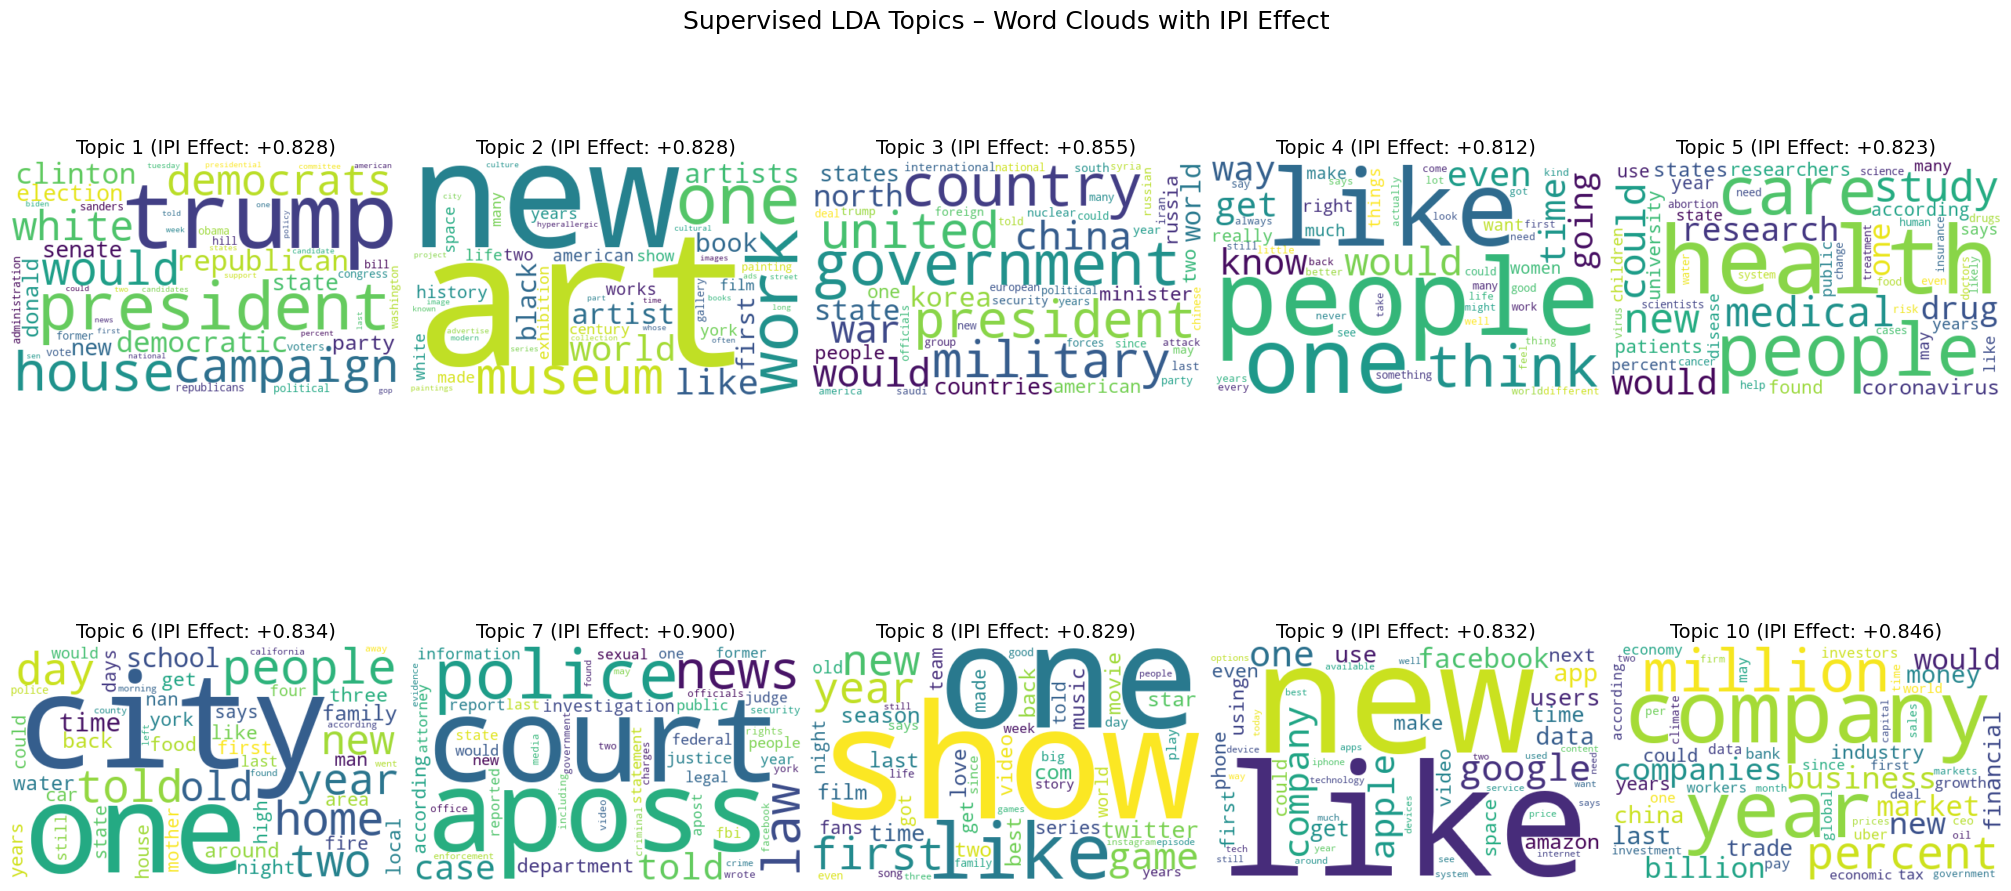

In [ ]:
# Visualize the top topics and their relationship to the IPI values
fig, axes = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    # Get topic words and their weights
    if idx < num_topics:  # Make sure we don't exceed the number of topics
        # Get the top 50 words for this topic
        top_words = slda_model.get_topic_words(idx, top_n=50)
        
        # Create dictionary for the wordcloud
        topic_dict = {word: weight for word, weight in top_words}
        
        # Create wordcloud
        wc = WordCloud(width=500, height=300, background_color='white', max_words=50)
        wc.generate_from_frequencies(topic_dict)
        ax.imshow(wc, interpolation='bilinear')
        
        # Add title with regression coefficient to show topic-IPI relationship
        coef = topic_coefs[idx]
        coef_sign = "+" if coef > 0 else ""
        ax.set_title(f'Topic {idx + 1} (IPI Effect: {coef_sign}{coef:.3f})', fontsize=14)
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off extra subplots if any

plt.suptitle('Supervised LDA Topics – Word Clouds with IPI Effect', fontsize=18)
plt.show()

In [ ]:
# Save the model
import os

# Create directory if it doesn't exist
os.makedirs("../models/topic_model", exist_ok=True)

# Save the sLDA model using tomotopy's native save method
slda_model.save("../models/topic_model/slda_model")

print("Model saved")

Model saved


### Topic Extraction & Analysis

In [ ]:
# Step 1: Extract document-topic distributions for training set
doc_topic_dists = [doc.get_topic_dist() for doc in slda_model.docs]

# Create topic column names
topic_cols = [f'topic_{i}' for i in range(num_topics)]

# Create a DataFrame with topic distributions
df_topics = pd.DataFrame(doc_topic_dists, columns=topic_cols)

# Combine with training metadata
df_meta = df_train[['date', 'publication', 'month']].reset_index(drop=True).copy()

# Ensure same length
df_meta = df_meta.iloc[:len(doc_topic_dists)].copy()

# Merge topics with metadata
df_combined = pd.concat([df_meta, df_topics], axis=1)

# Aggregate topic shares by month and publisher
df_monthly_pub = df_combined.groupby(['month', 'publication'])[topic_cols].mean().reset_index()

# Save
df_monthly_pub.to_csv('../data/processed/monthly_topic_shares_by_publisher_sLDA.csv', index=False)

print("Saved: 'monthly_topic_shares_by_publisher_sLDA.csv'")
print(df_monthly_pub.head())


Saved: 'monthly_topic_shares_by_publisher_sLDA.csv'
Head of 'monthly_topic_shares_by_publisher_sLDA.csv':


,month,publication,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2016-01,Business Insider,0.011177,0.033370,0.079773,0.097302,0.074727,0.098848,0.103577,0.145640,0.144397,0.211189
1,2016-01,CNBC,0.077620,0.006541,0.070780,0.080099,0.067432,0.057566,0.065173,0.030000,0.051948,0.492840
2,2016-01,CNN,0.246734,0.025729,0.148172,0.097992,0.076219,0.111124,0.125382,0.066957,0.043887,0.057804
3,2016-01,Economist,0.054624,0.092408,0.274799,0.152614,0.038277,0.093722,0.038525,0.036632,0.055162,0.163236
4,2016-01,Gizmodo,0.030501,0.068285,0.028256,0.108532,0.118862,0.074730,0.098407,0.045594,0.361619,0.065214


### Compare topic trends with IPI values

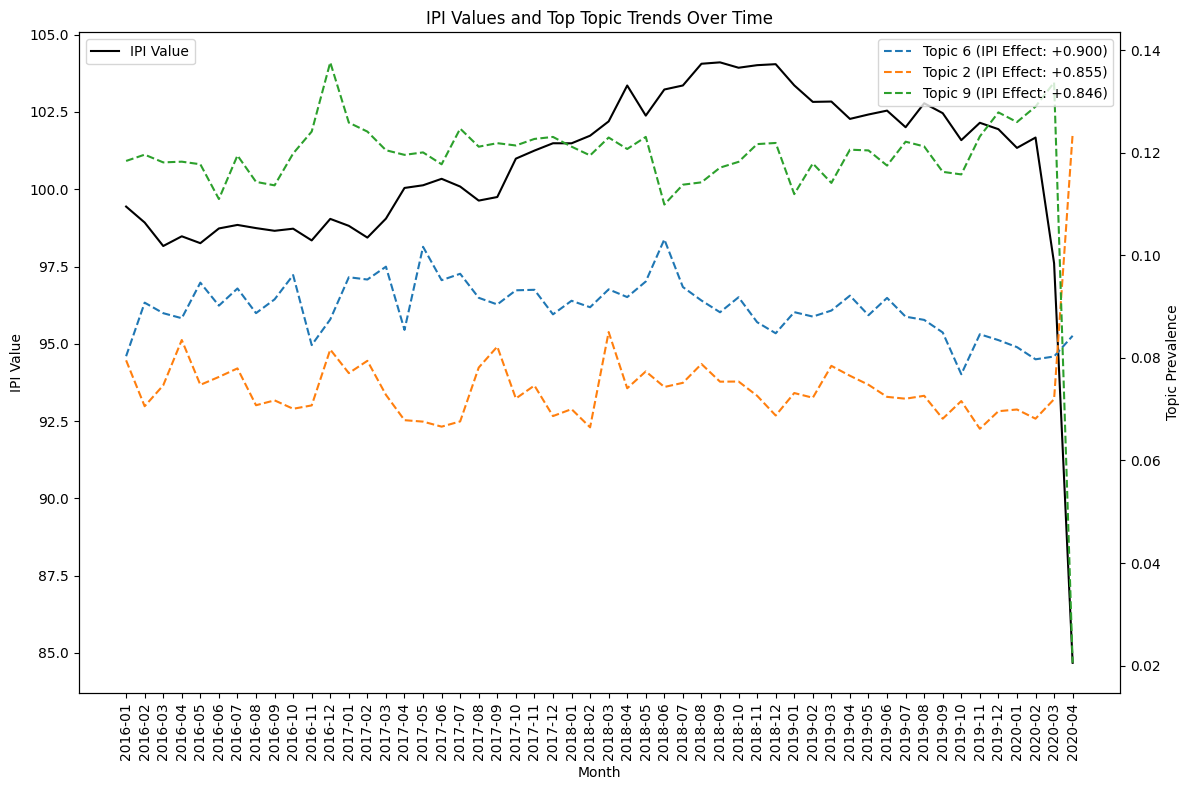

In [ ]:
# Analyze the relationship between topic prevalence and IPI values (TRAIN SET ONLY)

# Get average IPI by month for full dataset (df_ipi likely contains all data)
monthly_ipi = df_ipi.groupby('month')['ipi_value'].mean().reset_index()

# Get average topic distributions by month (train only)
monthly_topics = df_monthly_pub.groupby('month')[topic_cols].mean().reset_index()

# Merge the data
df_trends = pd.merge(monthly_topics, monthly_ipi, on='month', how='inner')

# Plot the trends of the top 3 most influential topics (based on regression coefficients)
topic_importance = [(i, abs(c)) for i, c in enumerate(topic_coefs)]
top_topics = sorted(topic_importance, key=lambda x: x[1], reverse=True)[:3]

plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

months = df_trends['month'].astype(str).tolist()
ax1.plot(months, df_trends['ipi_value'], 'k-', label='IPI Value')

for topic_idx, importance in top_topics:
    topic_col = f'topic_{topic_idx}'
    coef = topic_coefs[topic_idx]
    coef_sign = "+" if coef > 0 else ""
    ax2.plot(months, df_trends[topic_col], '--', 
            label=f'Topic {topic_idx} (IPI Effect: {coef_sign}{coef:.3f})')

ax1.set_xlabel('Month')
ax1.set_ylabel('IPI Value')
ax2.set_ylabel('Topic Prevalence')
ax1.set_xticklabels(months, rotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('IPI Values and Top Topic Trends Over Time (Train Set)')
plt.tight_layout()
plt.show()


### Output

The output CSV file (`monthly_topic_shares_by_publisher_sLDA.csv`) contains the monthly topic distributions for each publisher, which can be used for further analysis or visualization.